<a href="https://colab.research.google.com/github/yoo9519-AIdev/SNU_AI/blob/main/pytorch_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning==0.8.1

     |████████████████████████████████| 296kB 3.6MB/s 
     |████████████████████████████████| 829kB 70.9MB/s 
     |████████████████████████████████| 276kB 74.2MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=f3b165603acf0e69553eed75670c6f4d369f13b5b4fc0d2a877e7a34f364fc5f
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=0470c5b0e5254cc4a21c954ad3e4e2be55bb4292d15e922bff82c6cde5cd339b
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [15]:
import os
import random as rn
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
import matplotlib.pyplot as plt

In [14]:
os.environ['PYTHONHASHSEED'] = '01033649095'
np.random.seed(42)
rn.seed(12345)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

In [42]:
glob_image = glob('/content/drive/MyDrive/SNUBH_AI_project/Xray_OSA/real_data/raw_images_merge/*.jpg')
len(glob_image)

4698

In [55]:
df = pd.read_csv('/content/drive/MyDrive/SNUBH_AI_project/Xray_OSA/real_data/df2_merge_toy.csv')
df

,Unnamed: 0,case_id,hos_id,age,sex,cephalo_d,filename,ahi,ahi_osa,anyosa,modsev,set
0,1,ceph-00001,10003138,43,0,2017-12-22,10003138_20200610_20171222204955_Cephalometry.jpg,7.0,mild,1,0,train
1,2,ceph-00002,10013483,85,1,2015-05-08,10013483_20200609_20150508080420_Cephalometry.jpg,86.7,severe,1,1,train
2,3,ceph-00003,10024197,68,0,2017-02-22,10024197_20200608_20170222162813_Cephalometry.jpg,64.1,severe,1,1,train
3,4,ceph-00004,10036260,59,0,2019-11-18,10036260_20200609_20191118074354_Cephalometry.jpg,33.2,severe,1,1,train
4,5,ceph-00005,10048737,65,1,2016-04-18,10048737_20200608_20160418111134_Cephalometry.jpg,54.4,severe,1,1,test
...,...,...,...,...,...,...,...,...,...,...,...,...
4575,4576,ctrl-02286,10029743,66,0,2018-01-17,10029743_20200825_20180117144732_Cephalometry.jpg,NaN,no,0,0,test
4576,4577,ctrl-02287,11161741,59,1,2015-10-28,11161741_20200825_20151028151049_Cephalometry.jpg,NaN,no,0,0,train
4577,4578,ctrl-02288,31044686,68,0,2019-05-17,31044686_20200825_20190517115221_Cephalometry.jpg,NaN,no,0,0,train
4578,4579,ctrl-02289,17827258,61,1,2019-06-27,17827258_20200825_20190627092132_Cephalometry.jpg,NaN,no,0,0,test


In [48]:
# img_len = []
# df_len = []

# for img in glob_image:
#     img_len.append(img)
    
# for csv_name in df['filename']:
#     df_len.append(csv_name)
    
# print(len(img_len))
# print(len(df_len))

# match = dict(zip(img_len, df_len))
# len(match)
# print(match)

# 값 제대로 매칭 안됨. 쓰지 말 것.

4698
4580


4580

In [57]:
data_image_paths = {os.path.basename(x): x for x in glob_image}
df['path'] = df['filename'].map(data_image_paths.get)
df['ahi_osa'] = df['ahi_osa'].map(lambda x: x.replace('no', 'normal'))

In [58]:
normal_images = glob_image
normal_data = {'path': normal_images, 'ahi_osa': 'Normal'}
df1 = pd.DataFrame(normal_data)
df = pd.concat([df,df1], ignore_index=True, axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,ceph-00001,10003138.0,43.0,0.0,2017-12-22,10003138_20200610_20171222204955_Cephalometry.jpg,7.0,mild,1.0,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
1,2.0,ceph-00002,10013483.0,85.0,1.0,2015-05-08,10013483_20200609_20150508080420_Cephalometry.jpg,86.7,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
2,3.0,ceph-00003,10024197.0,68.0,0.0,2017-02-22,10024197_20200608_20170222162813_Cephalometry.jpg,64.1,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
3,4.0,ceph-00004,10036260.0,59.0,0.0,2019-11-18,10036260_20200609_20191118074354_Cephalometry.jpg,33.2,severe,1.0,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4,5.0,ceph-00005,10048737.0,65.0,1.0,2016-04-18,10048737_20200608_20160418111134_Cephalometry.jpg,54.4,severe,1.0,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal
4696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,Normal


In [59]:
# df.to_csv('check.csv')

In [60]:
df = df[[6, 8, 10, 11, 12]]
df

,6,8,10,11,12
0,10003138_20200610_20171222204955_Cephalometry.jpg,mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
1,10013483_20200609_20150508080420_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
2,10024197_20200608_20170222162813_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
3,10036260_20200609_20191118074354_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4,10048737_20200608_20160418111134_Cephalometry.jpg,severe,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
...,...,...,...,...,...
4693,NaN,NaN,NaN,NaN,NaN
4694,NaN,NaN,NaN,NaN,NaN
4695,NaN,NaN,NaN,NaN,NaN
4696,NaN,NaN,NaN,NaN,NaN


In [70]:
df = df.dropna(axis=0)
df[8] = df[8].replace('normalrmal', 'normal')
df

,6,8,10,11,12
0,10003138_20200610_20171222204955_Cephalometry.jpg,mild,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
1,10013483_20200609_20150508080420_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
2,10024197_20200608_20170222162813_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
3,10036260_20200609_20191118074354_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4,10048737_20200608_20160418111134_Cephalometry.jpg,severe,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
...,...,...,...,...,...
4575,10029743_20200825_20180117144732_Cephalometry.jpg,normal,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4576,11161741_20200825_20151028151049_Cephalometry.jpg,normal,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4577,31044686_20200825_20190517115221_Cephalometry.jpg,normal,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...
4578,17827258_20200825_20190627092132_Cephalometry.jpg,normal,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...


In [63]:
# df.to_csv('last_check.csv')

normal      2532
severe      1035
moderate     519
mild         494
Name: 8, dtype: int64


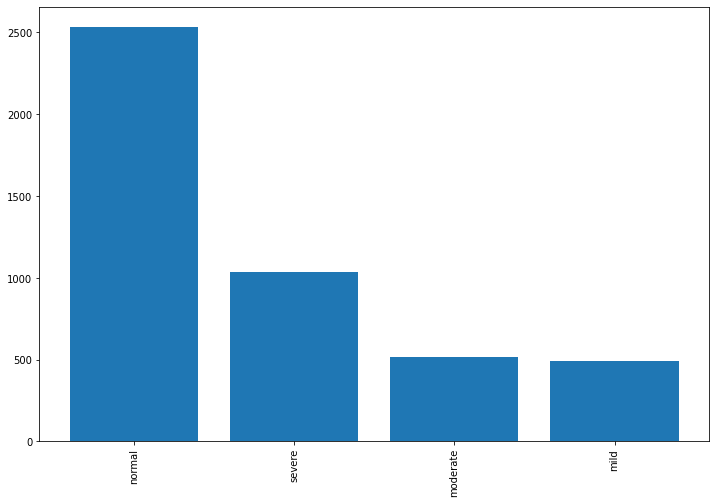

In [71]:
label_counts = df[8].value_counts()
print(label_counts)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [78]:
from itertools import chain
all_labels = np.unique(list(chain(*df[8].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df[8].map(lambda finding: 1 if c_label in finding else 0)

df.sample(3)

All Labels (4): ['mild', 'moderate', 'normal', 'severe']


,6,8,10,11,12,mild,moderate,normal,severe
1397,25156267_20200608_20151002103942_Cephalometry.jpg,severe,1.0,valid,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,0,1
603,16815409_20200609_20131025130517_Cephalometry.jpg,moderate,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,0,0
4483,29232846_20200825_20180423102840_Cephalometry.jpg,normal,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,1,0


In [ ]:
df['disease_vec'] = df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [82]:
train_df, valid_df, test_df = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [83]:
print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])
train_df.sample(3)

train 2748 validation 916 test 916


,6,8,10,11,12,mild,moderate,normal,severe,disease_vec
2872,11071792_20200824_20181212133004_Cephalometry.jpg,normal,0.0,valid,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,1,0,"[0, 0, 1, 0]"
1354,24796105_20200608_20160527094837_Cephalometry.jpg,moderate,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,0,0,"[0, 1, 0, 0]"
2550,22227627_20200824_20131111094858_Cephalometry.jpg,normal,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,1,0,"[0, 0, 1, 0]"


In [84]:
def compute_class_freqs(labels):
    
    N = len(labels)
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [85]:
train_labels = []
ds_len = train_df.shape[0]

for inx in range(ds_len):
    row = train_df.iloc[inx]
    vec = np.array(row['disease_vec'], dtype=np.int)
    train_labels.append(vec)

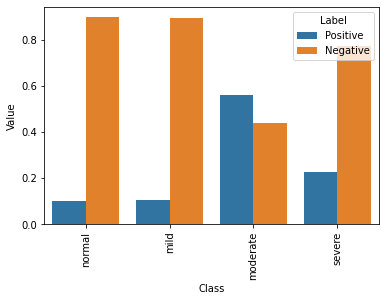

In [86]:
freq_pos, freq_neg = compute_class_freqs(train_labels)
freq_pos

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [87]:
def weighted_loss(y_true, y_pred, pos_weights, neg_weights, epsilon=1e-7):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += -(torch.mean( pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon) + \
                                neg_weights[i] * (1 - y_true[:,i]) * torch.log(1 - y_pred[:,i] + epsilon), axis = 0))
            
        return loss

In [88]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

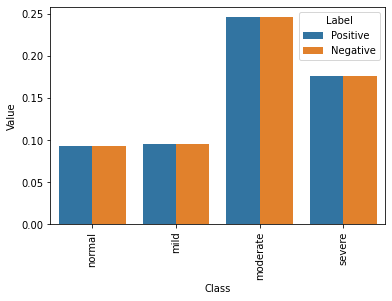

In [89]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

In [90]:
train_df

,6,8,10,11,12,mild,moderate,normal,severe,disease_vec
4502,24953946_20200825_20180911102435_Cephalometry.jpg,normal,0.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,1,0,"[0, 0, 1, 0]"
2283,32353871_20200609_20200228192314_Cephalometry.jpg,moderate,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,0,0,"[0, 1, 0, 0]"
812,19771940_20200609_20150320101958_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,0,1,"[0, 0, 0, 1]"
4070,11263407_20200825_20190215101520_Cephalometry.jpg,normal,0.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,1,0,"[0, 0, 1, 0]"
2140,30157394_20200609_20181115152832_Cephalometry.jpg,severe,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,0,1,"[0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...
374,13982247_20200609_20181205162348_Cephalometry.jpg,moderate,1.0,valid,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,0,0,"[0, 1, 0, 0]"
2431,24138987_20200824_20141224091831_Cephalometry.jpg,normal,0.0,valid,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,1,0,"[0, 0, 1, 0]"
743,18667505_20200608_20160402080154_Cephalometry.jpg,moderate,1.0,test,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,1,0,0,"[0, 1, 0, 0]"
1074,22976183_20200608_20160708091709_Cephalometry.jpg,severe,1.0,train,/content/drive/MyDrive/SNUBH_AI_project/Xray_O...,0,0,0,1,"[0, 0, 0, 1]"


In [98]:
from PIL import Image
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, transforms=None):
        self.data_frame = data_frame
        self.transforms = transforms
        self.len = data_frame.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        row = self.data_frame.iloc[index]
        address = row[12]
        x = Image.open(address).convert('RGB')
        
        vec = np.array(row['disease_vec'], dtype=np.float)
        y = torch.FloatTensor(vec)
        
        if self.transforms:
            x = self.transforms(x)
        return x, y
    

train_transform = transforms.Compose([ 
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.63, 1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

test_transform = transforms.Compose([ 
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
dsetTrain = CustomDataset(train_df, train_transform) 
dsetVal = CustomDataset(valid_df, test_transform) 
dsetTest = CustomDataset(test_df, test_transform)

trainloader = torch.utils.data.DataLoader(dataset = dsetTrain, batch_size = 12, shuffle = True, num_workers = 8 )
valloader = torch.utils.data.DataLoader(dataset = dsetVal, batch_size = 12, shuffle = False, num_workers = 8 )
testloader = torch.utils.data.DataLoader(dataset = dsetTest, batch_size = 100, shuffle = False, num_workers = 8 )

In [99]:
class DensModel(LightningModule):

    def __init__(self):
        super().__init__()
               
        # self.metric = Accuracy()
        self.densenet201 = torchvision.models.densenet201(pretrained=True)
        
        feature_extracting = True
        self.set_parameter_requires_grad(self.densenet201, feature_extracting)

        num_ftrs = self.densenet201.classifier.in_features

        self.densenet201.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 14),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet201(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam (model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')

        return [optimizer], [scheduler]

    def set_parameter_requires_grad(self, model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = False


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        # loss = F.binary_cross_entropy(y_hat, y, size_average = True)
        loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)
        
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}


    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        # loss = F.binary_cross_entropy(y_hat, y, size_average = True)
        loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)
        # acc = self.metric(y_hat, y)
    
        return {'val_loss': loss}


    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()

        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}


    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # loss = F.binary_cross_entropy(y_hat, y, size_average = True)
        
        loss = weighted_loss(y, y_hat, pos_weights, neg_weights, epsilon=1e-7)

        return {'test_loss': loss}


    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        tensorboard_logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': tensorboard_logs}


    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

In [100]:
model = DensModel()

early_stopping = EarlyStopping('val_loss')
checkpoint_callback = ModelCheckpoint(verbose=False, monitor='avg_val_loss', mode='min')

trainer = Trainer(gpus=1, max_epochs=5, checkpoint_callback=checkpoint_callback, early_stop_callback=early_stopping)
trainer.fit(model, trainloader, valloader)

trainer.test(model, test_dataloaders=testloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type     | Params
-----------------------------------------
0 | densenet201 | DenseNet | 18 M  


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_loss': tensor(0.8061, device='cuda:0'),
 'test_loss': tensor(0.8061, device='cuda:0')}
--------------------------------------------------------------------------------



In [101]:
def get_roc_curve(labels, predicted_vals, gt_labels):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = gt_labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

In [102]:
for x, y in testloader:
    
    model.eval()
    x = torch.autograd.Variable(x).cuda()
    
    
    with torch.no_grad():
        outputs = model(x)
        print(outputs.shape)
        
        gt_labels = y.cpu().numpy()
        predicted_vals = outputs.cpu().numpy()
        
        for c_label, s_count in zip(all_labels, 100*np.mean(y.numpy(),0)):
            print('%s: %2.2f%%' % (c_label, s_count))
        break

torch.Size([100, 14])
mild: 10.00%
moderate: 14.00%
normal: 54.00%
severe: 22.00%


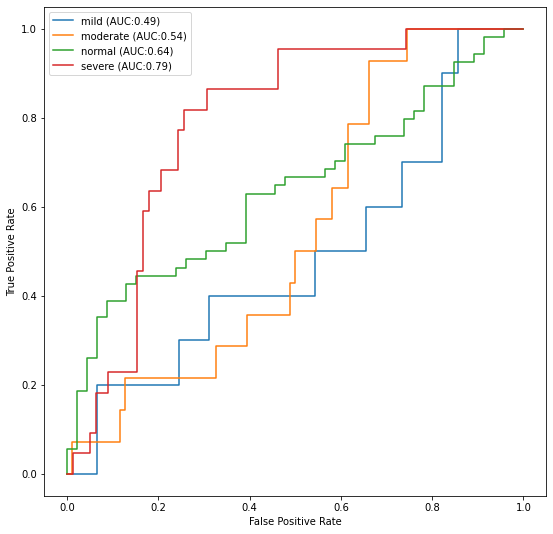

In [103]:
from sklearn.metrics import roc_curve, auc
test_Y = y.numpy()
pred_Y = predicted_vals
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')